In [1]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from aero_design_functions import get_design_functions, single_point_design
from scipy.optimize import fsolve
from lacbox.io import load_pwr, load_ind, load_inds, load_ae, load_pc
from lacbox.test import test_data_path
from myteampack import MyHTC
from pathlib import Path
from our_functions import extract_bd_master

plt.rcParams.update({'font.family': 'serif', 'font.size':14})


## COMPUTE REMODEL PARAMETERS

In [2]:
# compute R_Y and V_RATED_Y

#Former class IA
V_rated_X = 11.4  # m/s
I_rated_X = 0.16
R_X = 89.17  # m

#New Class IIIB
I_rated_Y = 0.14

# Define the system of nonlinear equations
def equations(vars):
    V_rated_Y, R_Y = vars
    eq1 = V_rated_Y - (R_X / R_Y)**(2/3) * V_rated_X
    eq2 = R_Y - ((V_rated_X * (1 + 2 * I_rated_X)) / (V_rated_Y * (1 + 2 * I_rated_Y)))**(2/3) * R_X
    return [eq1, eq2]

# Initial guesses for V_rated_Y and R_Y
initial_guess = [1, 1]

# Solve the system of equations
solution = fsolve(equations, initial_guess)

# Extract the solution
V_rated_Y, R_Y = solution

print(f'type      |    R     |    V      ')
print(f'DTU 10 MW |  {R_X:.3f}  |  {V_rated_X:.3f}')
print(f'Group1    |  {R_Y:.3f}  |  {V_rated_Y:.3f}')


# modification: new blade is 1% smaller to reduce loads
R_Y = R_Y *0.99
V_rated_Y = (R_X/R_Y)**(2/3)*V_rated_X

print(f'Nicola    |  {R_Y:.3f}  |  {V_rated_Y:.3f}')

print()
print('final values')
print(f"V_rated_Y: {V_rated_Y} m/s")
print(f"R_Y: {R_Y} m")
#

type      |    R     |    V      
DTU 10 MW |  89.170  |  11.400
Group1    |  92.524  |  11.123
Nicola    |  91.599  |  11.198

final values
V_rated_Y: 11.197563974599802 m/s
R_Y: 91.59899634459074 m


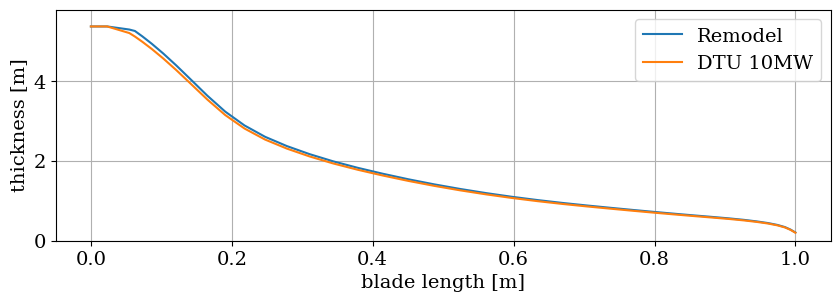

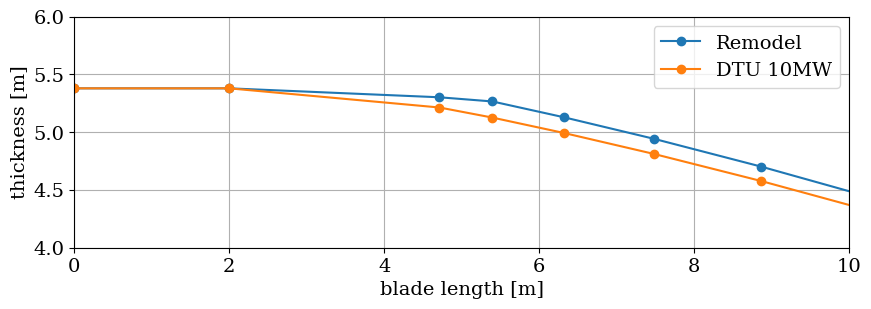

In [3]:
# new thickness

Data_ae = load_ae("dtu_10mw/data/DTU_10MW_RWT_ae.dat")

# Data from the DTU 10MW
data_ae = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }

abs_t_dtu = data_ae["chord"]*data_ae["rel_th"]/100 # dtu thickness
abs_t=data_ae["chord"]*data_ae["rel_th"]/100*R_Y/R_X # new thickness

# to force the thickness at the root and make it smoother
abs_t[0:2]=data_ae["chord"][0:2]
abs_t[2]=0.99*abs_t[2]

#plot the former blade shape and the new one
plt.figure(figsize=(10,3))
plt.plot(data_ae['curve']/max(data_ae['curve']), abs_t, label='Remodel')
plt.plot(data_ae['curve']/max(data_ae['curve']), abs_t_dtu, label='DTU 10MW')
plt.ylim(0,5.8)
plt.xlabel('blade length [m]')
plt.ylabel('thickness [m]')
plt.grid()
plt.legend()
plt.savefig('plots/bd_thickness_blade_span.pdf', format='pdf')
plt.show()


plt.figure(figsize=(10,3))
plt.plot(data_ae['curve'], abs_t,     marker='o', label='Remodel')
plt.plot(data_ae['curve'], abs_t_dtu, marker='o', label='DTU 10MW')
plt.xlabel('blade length [m]')
plt.ylabel('thickness [m]')
plt.grid()
plt.legend()
plt.xlim(0,10)
plt.ylim(4, 6)
plt.show()


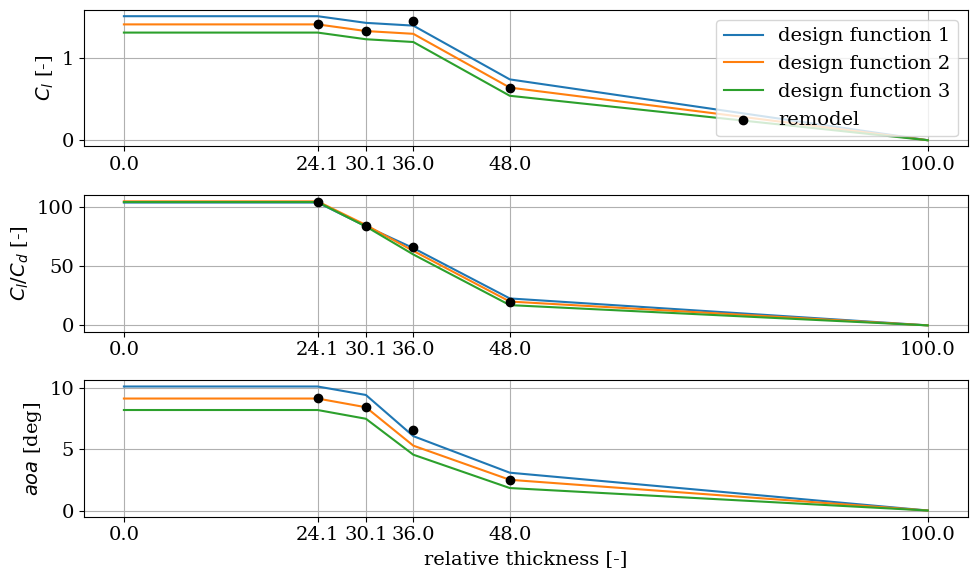

In [4]:
# design function

# Define a cl plot for the 10MW using the pc.dat
Data_cl = load_pc("dtu_10mw/data/DTU_10MW_RWT_pc.dat") # return a list per blade
n = len(Data_cl)-2 # exclude airfoils of 100% and 60% relative thickness
des_param = np.zeros((4,n)) # relative thickness, cl design, cd design, AoA design
arg_0 = [63,63,63,58] # indices of the AoAs before stall

for k in range(n):
    cl_max = np.amax(Data_cl[k]["cl"][50:arg_0[k]])  # Maximum lift coefficient within the range
    cl_des = cl_max - 0.4

    # Finding corresponding AoA
    arg_max = np.where(Data_cl[k]["cl"] == cl_max)
    aoa_max = Data_cl[k]["aoa_deg"][arg_max]
    
    # Interpolating to find AoA and Cd of Cl design
    aoa_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["aoa_deg"][50:arg_0[k]])
    cd_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["cd"][50:arg_0[k]])
    des_param[:, k] = [Data_cl[k]["tc"], cl_des, cd_des, aoa_des]

_, _, _, tc_vals, cl_vals1, cd_vals1, aoa_vals1 = get_design_functions(1)
_, _, _, tc_vals, cl_vals2, cd_vals2, aoa_vals2 = get_design_functions(2)
_, _, _, tc_vals, cl_vals3, cd_vals3, aoa_vals3 = get_design_functions(3)


fig1, axs1 = plt.subplots(3, 1, num=1, figsize=(10,6), clear=True) 
# lift
axs1[0].plot(tc_vals, cl_vals1, label='design function 1')
axs1[0].plot(tc_vals, cl_vals2, label='design function 2')
axs1[0].plot(tc_vals, cl_vals3, label='design function 3')
axs1[0].scatter(des_param[0], des_param[1], label='remodel', color='k',zorder=3)
axs1[0].set_ylabel('$C_l$ [-]')
axs1[0].legend()
axs1[0].grid()

# lift / drag
axs1[1].plot(tc_vals, cl_vals1/cd_vals1)
axs1[1].plot(tc_vals, cl_vals2/cd_vals2)
axs1[1].plot(tc_vals, cl_vals3/cd_vals3)
axs1[1].scatter(des_param[0], des_param[1]/des_param[2], color='k', zorder=3)
axs1[1].set_ylabel('$C_l/C_d$ [-]')
axs1[1].grid()

# AoA
axs1[2].plot(tc_vals, aoa_vals1)
axs1[2].plot(tc_vals, aoa_vals2)
axs1[2].plot(tc_vals, aoa_vals3)
axs1[2].scatter(des_param[0], des_param[3], color='k', zorder=3)
axs1[2].set_ylabel('$aoa$ [deg]')
axs1[2].set_xlabel('relative thickness [-]')
axs1[2].grid()

axs1[2].set_xticks(tc_vals)  # for the bottom plot
plt.setp(axs1, xticks=tc_vals)  # apply xticks for all subplots

plt.tight_layout()
plt.savefig('plots/bd_computed_vs_design funct.pdf', format='pdf')
plt.show()



In [5]:
# evaluate optimal blade hape with single_point_design function
# change in max chord

r_hub = 2.8  # Hub radius [m]
r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]
chord_root = 5.38  # Chord size at the root [m]
chord_max_redesign = 6.3 
chord_max = chord_max_redesign*1.01 # max chord increased by 1% to increase power production

t = abs_t # Absolute thickness [m]
B = 3  # Number of blades [#]
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)

TSR = np.linspace(6,12,20)
CP_list = []
for tsr in TSR:
    # %% Solving for the a single design
    chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
        r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
    CP_list.append(CP)

CP_max=np.amax(CP_list)
TSR_max=TSR[np.argmax(CP_list)]


print('best blade:')
print('CP =', CP_max)
print('TSR =', TSR_max)



best blade:
CP = 0.44352485763123617
TSR = 7.2631578947368425


## CREATE NEW MASTER FILE

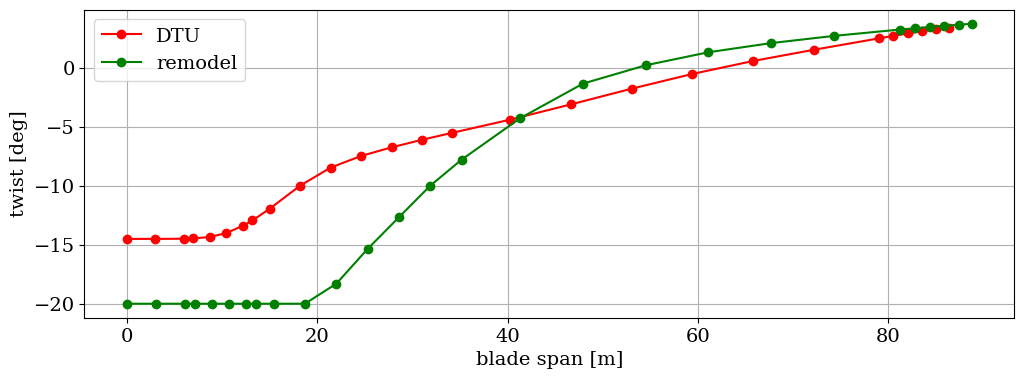

Data saved to remodel/_master/modify.txt
Data saved to remodel/data/remodel_ae.dat


In [ ]:
# new z and twist

r_hub = 2.8  # Hub radius [m]
r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]
scale = (R_Y - r_hub)/(R_X - r_hub)
tsr = 7.2631578947368425

cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)


file_path = "dtu_10mw/_master/dtu_10mw.htc"
data_master = extract_bd_master(file_path)

new_z =data_master['z']*scale
new_twist = -np.interp(new_z, r, twist)             # minus sign to be consistent with htc

plt.figure(figsize=(12,4))
plt.plot(data_master['z'], data_master['twist'], marker='o', label='DTU', color='r')
plt.plot(new_z, new_twist, marker='o',  label='remodel', color='g')
plt.xlabel('blade span [m]')
plt.ylabel('twist [deg]')
plt.grid()
plt.legend()
plt.show()


# write down changes

# blade definition in master file
output_file = 'remodel/_master/modify.txt'

# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'# change new_htc_structure_blade1 with this\n\n')
    for i in range(len(data_master['number'])):
        # Construct the formatted string
        line = f"sec {data_master['number'][i]} {data_master['x'][i]:.5E} {data_master['y'][i]:.5E} {new_z[i]:.5E} {new_twist[i]:.5E} ;\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")


# aerodynamic definition
new_curve = r - r_hub

output_file = 'remodel/data/remodel_ae.dat'

# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'1\n')
    file.write(f'1  40\n')
    for i in range(40):
        # Construct the formatted string
        line = f"{new_curve[i]:.5E} {chord[i]:.5E} {tc[i]:.5E} 1  ;\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")


In [14]:
# compute omega

omega_max_DTU = 9.60
omega_max_formula = TSR_max * V_rated_Y / R_Y * 60 / (2*np.pi)

tipSpeedMax = 100
omega_max_TS = tipSpeedMax/R_Y * 60 / (2*np.pi)

print('omega DTU            ', omega_max_DTU)
print('omega from TSR max   ', omega_max_formula)
print('omega from tip speed', omega_max_TS)

omega DTU             9.6
omega from TSR max    8.478708506949244
omega from tip speed 10.425110499671584


## RUN SIMULATIONS

In [30]:
# multitsr input file

# remodel
TSR_range = np.arange(5.5,10.5,0.2)
V_rated_Y_range = np.arange(V_rated_Y, V_rated_Y + len(TSR_range) * 0.001 - 0.001, 0.001)
omega_range = TSR_range * V_rated_Y_range / R_Y * 60 / (2*np.pi)

output_file = 'remodel/data/remodel_multitsr.opt'

# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'{int(len(TSR_range))} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    for i in range(len(TSR_range)):
        # Construct the formatted string
        line = f"          {V_rated_Y_range[i]:6.6f}          0.000000          {omega_range[i]:6.6f}          500.000000          1000.000000\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")




# for DTU 10 MW
V_rated_X_range = np.arange(V_rated_X, V_rated_X + len(TSR_range) * 0.001 - 0.001, 0.001)
omega_range_X = TSR_range * V_rated_X_range/ R_X * 60 / (2*np.pi)

output_file = 'dtu_10mw/data/dtu_10mw_multitsr.opt'

# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'{int(len(TSR_range))} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    for i in range(len(TSR_range)):
        # Construct the formatted string
        line = f"          {V_rated_Y_range[i]:6.6f}          0.000000          {omega_range[i]:6.6f}          500.000000          1000.000000\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")



Data saved to remodel/data/remodel_multitsr.opt
Data saved to dtu_10mw/data/dtu_10mw_multitsr.opt


## POST PROCESS

dict_keys(['s_m', 'a', 'ap', 'flow_angle_rad', 'aoa_rad', 'flow_speed_ms', 'Fx_Nm', 'Fy_Nm', 'M_Nmm', 'UX0_m', 'UY0_m', 'UZ0_m', 'twist_rad', 'X_AC0_m', 'Y_AC0_m', 'Z_AC0_m', 'Cl', 'Cd', 'Cm', 'CLp0_rad', 'CDp0_rad', 'CMp0_rad', 'F0', 'F_rad', 'CL_FS0', 'CLFS_rad', 'V_a_ms', 'V_t_ms', 'torsion_rad', 'vx_ms', 'vy_ms', 'chord_m', 'CT', 'CP', 'angle_rad', 'v_1', 'v_2', 'v_3'])


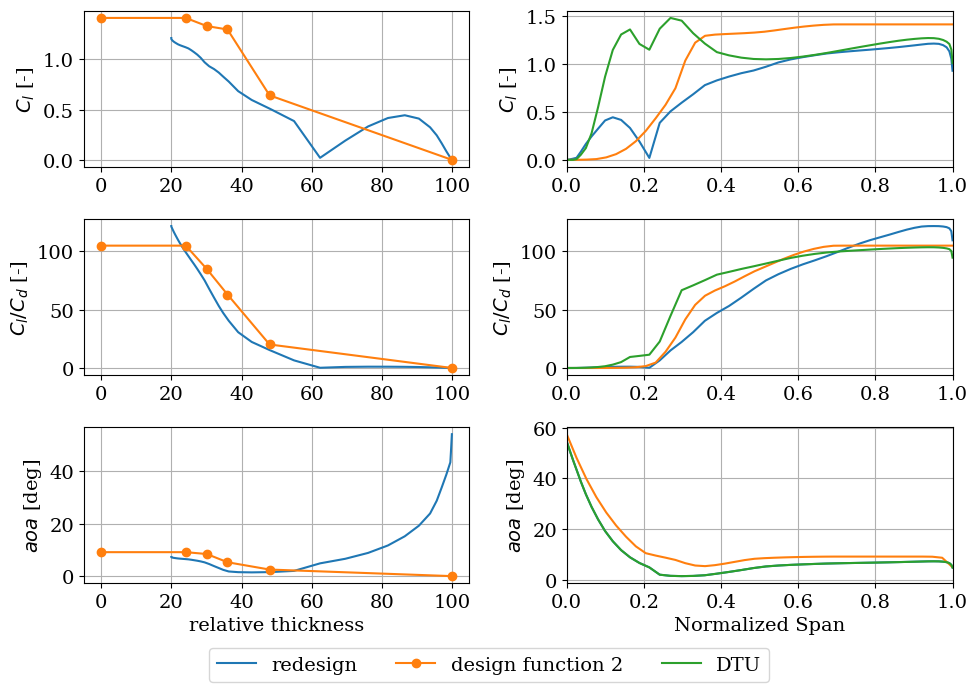

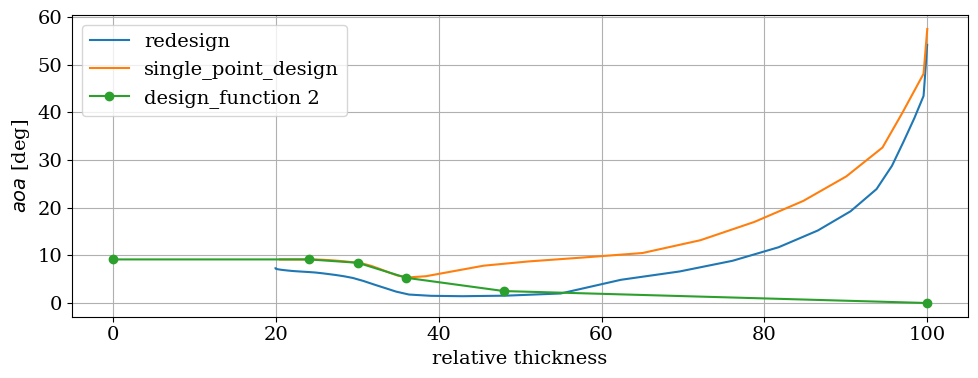

In [21]:
# open induction files
ind_data_path = 'remodel/res_hawc2s/remodel_hawc2s_1wsp_u11198.ind'
ind_data_DTU_10_path = 'dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind'

ind_data = load_ind(ind_data_path)
ind_data_DTU_10 = load_ind(ind_data_DTU_10_path)

# Print the names in the dict
print(ind_data.keys())

alpha_redesign = np.rad2deg(ind_data['aoa_rad'])
Cl_redesign = ind_data['Cl']
Cd_redesign = ind_data['Cd']
CP_redesign = ind_data['CP']
CT_redesign = ind_data['CT']
r_redesign = ind_data["s_m"]

alpha_DTU_10 = np.rad2deg(ind_data['aoa_rad'])
Cl_DTU_10 = ind_data_DTU_10['Cl']
Cd_DTU_10 = ind_data_DTU_10['Cd']
CP_DTU_10 = ind_data_DTU_10['CP']
CT_DTU_10 = ind_data_DTU_10['CT']
r_DTU_10 = ind_data_DTU_10["s_m"]

cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)

r_analytical = r - r_hub
Cl_analytical = cl
Cd_analytical = cd
alpha_analytical = aoa
a_analytical = a
CP_analytical = CLP
CT_analytical = CLT


r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]
_, _, _, tc_vals, cl_vals1, cd_vals1, aoa_vals1 = get_design_functions(1)
_, _, _, tc_vals, cl_vals2, cd_vals2, aoa_vals2 = get_design_functions(2)
_, _, _, tc_vals, cl_vals3, cd_vals3, aoa_vals3 = get_design_functions(3)

r_analytical = r-r_hub
new_tc = np.interp(ind_data['s_m'], r_analytical, tc)

fig1, axs1 = plt.subplots(3, 2, num=1, figsize=(10,7), clear=True) 
axs1[0,0].plot(new_tc[:-6], Cl_redesign[:-6], label='redesign')
axs1[0,0].plot(tc_vals, cl_vals2, marker='o', label='design function 2')
axs1[0,0].set_ylabel("$C_l$ [-]")
axs1[0,0].grid(True)  # Add grid

axs1[0,1].plot(r_redesign/(R_Y-r_hub), Cl_redesign)
axs1[0,1].plot(r_analytical/(R_Y-r_hub), Cl_analytical)
axs1[0,1].plot(r_DTU_10/(R_X-r_hub), Cl_DTU_10, label='DTU')
axs1[0,1].set_ylabel("$C_l$ [-]")
axs1[0,1].set_xlim(0, 1)
axs1[0,1].grid(True)  # Add grid


axs1[1,0].plot(new_tc[:-6], Cl_redesign[:-6]/Cd_redesign[:-6])
axs1[1,0].plot(tc_vals, cl_vals2/cd_vals2, marker='o')
axs1[1,0].set_ylabel("$C_l/C_d$ [-]")
axs1[1,0].grid(True)  # Add grid

axs1[1,1].plot(r_redesign/(R_Y-r_hub), Cl_redesign/Cd_redesign)
axs1[1,1].plot(r_analytical/(R_Y-r_hub), Cl_analytical/Cd_analytical)
axs1[1,1].plot(r_DTU_10/(R_X-r_hub), Cl_DTU_10/Cd_DTU_10)
axs1[1,1].set_ylabel("$C_l/C_d$ [-]")
axs1[1,1].set_xlim(0, 1)
axs1[1,1].grid(True)  # Add grid


axs1[2,0].plot(new_tc[:-6], alpha_redesign[:-6])
#axs1[2,0].plot(tc, alpha_analytical)
axs1[2,0].plot(tc_vals, aoa_vals2, marker='o')
axs1[2,0].set_ylabel("$aoa$ [deg]")
axs1[2,0].set_xlabel("relative thickness")
axs1[2,0].grid(True)  # Add grid

axs1[2,1].plot(r_redesign/(R_Y-r_hub), alpha_redesign)
axs1[2,1].plot(r_analytical/(R_Y-r_hub), alpha_analytical)
axs1[2,1].plot(r_DTU_10/(R_X-r_hub), alpha_DTU_10)
axs1[2,1].set_ylabel("$aoa$ [deg]")
axs1[2,1].set_xlabel("Normalized Span") 
axs1[2,1].set_xlim(0, 1)
axs1[2,1].grid(True)  # Add grid

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Add more space at the bottom if needed
fig1.legend(loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.005))
plt.savefig('03_part1_all.pdf', format='pdf')
plt.show()


plt.figure(figsize=(10,4))
plt.plot(new_tc[:-6], alpha_redesign[:-6], label='redesign')
plt.plot(tc[:-5], alpha_analytical[:-5], label='single_point_design')
plt.plot(tc_vals, aoa_vals2, marker='o', label='design_function 2')
plt.ylabel("$aoa$ [deg]")
plt.xlabel("relative thickness")
plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.savefig('03_part1_addition.pdf', format='pdf')
plt.show()

